<a href="https://colab.research.google.com/github/sdingx/ml-cv/blob/main/finalproj_ml_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # image plotting
import os
import time
from PIL import Image, ImageEnhance
import xml.etree.ElementTree as ET
from tensorflow.keras.preprocessing import image
from keras.models import load_model
import tensorflow as tf
from tensorflow import keras

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


## Read all images

In [ ]:
path = '/content/drive/My Drive/S23-ML/final/archive-2/'

In [ ]:
image_folder = path+"images/"
annot_folder = path+"annotations/"

# Define the label classes
class_name = ["with_mask", "without_mask"]

# Initialize empty lists for images and labels
images = []
# labels = []
all_bbox = []
all_mask_cats = []

# Loop through the annotation folder
for filename in os.listdir(annot_folder):
    if filename.endswith(".xml"):
        # Parse the XML annotation file
        annot_path = os.path.join(annot_folder, filename)
        tree = ET.parse(annot_path)
        root = tree.getroot()
        
        # Load the corresponding image
        image_filename = root.find("filename").text
        image_path = os.path.join(image_folder, image_filename)
        image = Image.open(image_path).convert("RGB")
        
        # Initialize empty lists for bounding boxes and labels
        bboxes = []
        mask_cats = []
        
        # Loop through all the objects in the XML file
        for obj in root.findall("object"):
            if obj.find("name").text in class_name:
                mask_cat = obj.find("name").text
                bndbox = obj.find("bndbox")
                xmin = int(bndbox.find("xmin").text)
                ymin = int(bndbox.find("ymin").text)
                xmax = int(bndbox.find("xmax").text)
                ymax = int(bndbox.find("ymax").text)
                
                # Add the bounding box and label to the lists
                all_bbox.append([xmin, ymin, xmax, ymax])
                all_mask_cats.append(mask_cat)
                cropped_image = image.crop((xmin, ymin, xmax, ymax))
                images.append(cropped_image)
                
        
        # all_bbox.append(bboxes)
        # all_mask_cats.append(mask_cats)
        
        # If at least one object with the desired class is found, append the image and labels to the lists
        # if len(mask_cats) > 0:
        #     images.append(image)
            
            
            # Set the label to 1 for "with_mask" or 0 for "without_mask"
            # labels.append([1 if mask_cat == "with_mask" else 0 for mask_cat in mask_cats])


In [ ]:
print("There are", len(images), "images,", len(all_bbox), "bounding boxes, and", len(all_mask_cats), "labels. Numbers", "match." if len(images) == len(all_mask_cats) else "don't match.")

There are 3949 images, 3949 bounding boxes, and 3949 labels. Numbers match.


In [ ]:
df = pd.DataFrame(all_mask_cats, images).reset_index()
df.columns = ["image", "mask_cat"]

In [ ]:
df.head(3)

,image,mask_cat
0,<PIL.Image.Image image mode=RGB size=96x116 at...,with_mask
1,<PIL.Image.Image image mode=RGB size=116x106 a...,with_mask
2,<PIL.Image.Image image mode=RGB size=25x22 at ...,with_mask


In [ ]:
grouped = df.groupby('mask_cat').count()

grouped = grouped.reset_index()

In [ ]:
grouped['mask_cat']

0       with_mask
1    without_mask
Name: mask_cat, dtype: object

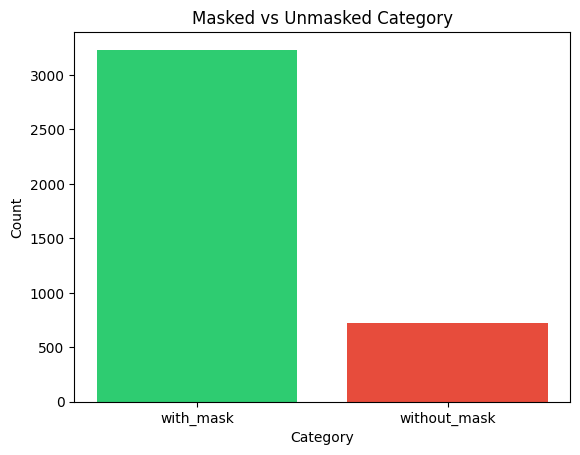

In [ ]:
import matplotlib.pyplot as plt

colors = ['#2ecc71', '#e74c3c']

plt.bar(grouped['mask_cat'], grouped['image'], color=colors)

plt.title('Masked vs Unmasked Category')
plt.xlabel('Category')
plt.ylabel('Count')

plt.show()

## Resampling

In [ ]:
import cv2
from sklearn.utils import shuffle

# assume that your original DataFrame is called `df`
majority_df = df[df['mask_cat'] == 'with_mask']
minority_df = df[df['mask_cat'] == 'without_mask']

# assume that `minority_df` has fewer rows than `majority_df`
# minority_upsampled = 

def keep_as_is(image):
  return image

def add_gaussian_noise(image, mean=0, std=10):
    # Convert PIL image to OpenCV format
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Generate Gaussian noise with the specified mean and standard deviation
    noise = np.random.normal(mean, std, image_cv.shape).astype(np.uint8)

    # Add the noise to the image
    noisy_image_cv = cv2.add(image_cv, noise)

    # Convert the noisy image back to PIL format
    noisy_image = Image.fromarray(cv2.cvtColor(noisy_image_cv, cv2.COLOR_BGR2RGB))

    return noisy_image

  
# def add_gaussian_noise(image, mean=0, std=10):
#     image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
#     noise = np.random.normal(mean, std, image_cv.shape).astype(np.uint8)
#     noisy_image_cv = cv2.add(image_cv, noise)
#     noisy_image = Image.fromarray(cv2.cvtColor(noisy_image_cv, cv2.COLOR_BGR2RGB))
#     return noisy_image

def flip_image(image):
    flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)
    return flipped_image

def rotate_image(image, angle=45):
    rotated_image = image.rotate(angle)
    return rotated_image

def change_brightness(image, factor=1.5):
    enhancer = ImageEnhance.Brightness(image)
    brightened_image = enhancer.enhance(factor)
    return brightened_image



def augment_minority_df(df):
    minority_augmented = pd.DataFrame(columns = ['image', 'mask_cat'])
    methods = [keep_as_is, rotate_image, flip_image, change_brightness]

    # Apply each augmentation method separately
    for i in range(4):
        #augmented_df = df.copy()

        #augmented_df['image'] = augmented_df['image'].apply(methods[i])

        # print(methods[i])
        
        new_method = pd.concat([pd.DataFrame(minority_df['image'].apply(methods[i])), pd.DataFrame(minority_df['mask_cat'])], axis=1)

        minority_augmented = pd.concat([minority_augmented, new_method], axis=0)

    # Concatenate augmented dataframes and sample based on majority_df length
    #minority_upsampled = minority_augmented.sample(n=majority_df.shape[0])

    # Shuffle the dataframe
    minority_augmented = shuffle(minority_augmented)

    return minority_augmented

def augment_majority_df(df):
    majority_augmented = pd.DataFrame(columns = ['image', 'mask_cat'])
    methods = [keep_as_is, rotate_image, flip_image, change_brightness]
    start = [0, int(1/4*majority_df.shape[0]), int(2/4*majority_df.shape[0]), int(3/4*majority_df.shape[0])]
    end = [int(1/4*majority_df.shape[0]), int(2/4*majority_df.shape[0]), int(3/4*majority_df.shape[0]), majority_df.shape[0]]

    # Apply each augmentation method separately
    for i in range(4):
        #augmented_df = df.copy()

        #augmented_df['image'] = augmented_df['image'].apply(methods[i])

        # print(methods[i])


        new_method = pd.concat([pd.DataFrame(majority_df['image'].iloc[start[i]:end[i]].apply(methods[i])), pd.DataFrame(majority_df['mask_cat'].iloc[start[i]:end[i]])], axis=1)

        majority_augmented = pd.concat([majority_augmented, new_method], axis=0)

    # Concatenate augmented dataframes and sample based on majority_df length
    #minority_upsampled = minority_augmented.sample(n=majority_df.shape[0])

    # Shuffle the dataframe
    majority_augmented = shuffle(majority_augmented)

    return majority_augmented

minority_upsampled = augment_minority_df(minority_df)

majority_augmented = augment_majority_df(majority_df)

In [ ]:
import matplotlib.pyplot as plt

majority_augmented.iloc[890]['image']
# minority_upsampled.iloc[1]

In [ ]:
minority_all = pd.concat([minority_df, minority_upsampled])

balanced_df = pd.concat([majority_augmented, minority_all])

balanced_df = balanced_df.sample(frac=1, random_state=42)


In [ ]:
threshold = np.round(len(df)*0.9)

train = df.iloc[0:int(threshold)]
test = df.iloc[int(threshold):]

In [ ]:
train['mask_cat'].value_counts()

with_mask       2928
without_mask     626
Name: mask_cat, dtype: int64

In [ ]:
test['mask_cat'].value_counts()

with_mask       304
without_mask     91
Name: mask_cat, dtype: int64

In [ ]:
train_with_mask = train[train['mask_cat'] == 'with_mask']['image']
train_without_mask = train[train['mask_cat'] == 'without_mask']['image']

test = test['image']

In [ ]:
test_res_df = pd.DataFrame(df.iloc[int(threshold):]['mask_cat'].map({'with_mask': 1, 'without_mask': 0}))

In [ ]:
test_res_df.to_csv('/content/drive/My Drive/S23-ML/final/test_res_new.csv')

In [ ]:
balanced_df.iloc[int(threshold):]['mask_cat'].value_counts()

without_mask    104
with_mask       101
Name: mask_cat, dtype: int64

In [ ]:
path_to_save = '/content/drive/My Drive/S23-ML/final/'



train_dir_with = os.path.join(path_to_save,'data_train_new/with_mask')

train_dir_without = os.path.join(path_to_save,'data_train_new/without_mask')

test_dir = os.path.join(path_to_save,'data_test_new')



os.makedirs(train_dir_with)
os.makedirs(train_dir_without)
# os.makedirs(os.path.join('/content/drive/My Drive/S23-ML/final/data_train/', 'without_mask' ))
os.makedirs(test_dir)


In [ ]:
 cnt = 0
 for image in train_with_mask:
   cnt += 1
   image.save(path_to_save+f'data_train_new/with_mask/{cnt}.png')

In [ ]:
 cnt = 0
 for image in train_without_mask:
   cnt += 1
   image.save(path_to_save+f'data_train_new/without_mask/{cnt}.png')

In [ ]:
 cnt = 0
 for image in test:
   cnt += 1
   image.save(path_to_save+f'data_test_new/{cnt}.png')